<a href="https://colab.research.google.com/github/aryan-at-ul/graph_neural_networks_basics/blob/main/gcn_cora_dataset_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

180224/168052 [================================] - 0s 1us/step


In [ ]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [ ]:
citations.sample(frac=1).head()

,target,source
1239,6213,1122425
1318,6214,628500
812,3229,1103960
3768,83847,66986
3956,103482,27510


In [ ]:
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t"
)
print("Papers :", papers.head())
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers :", papers.head())

Papers :      31336  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.1405  0.1406  \
0  1061127  0    0    0    0    0    0    0    0    0  ...       0       1   
1  1106406  0    0    0    0    0    0    0    0    0  ...       0       0   
2    13195  0    0    0    0    0    0    0    0    0  ...       0       0   
3    37879  0    0    0    0    0    0    0    0    0  ...       0       0   
4  1126012  0    0    0    0    0    0    0    0    0  ...       0       0   

   1.19  0.1407  0.1408  0.1409  0.1410  0.1411  0.1412  \
0     0       0       0       0       0       0       0   
1     0       0       0       0       0       0       0   
2     0       0       0       0       0       0       0   
3     0       0       0       0       0       0       0   
4     1       0       0       0       0       0       0   

          Neural_Networks  
0           Rule_Learning  
1  Reinforcement_Learning  
2  Reinforcement_Learning  
3   Probabilistic_Methods  
4   Probabilistic_Methods  

In [ ]:
print(papers.head(1))

   paper_id  term_0  term_1  term_2  term_3  term_4  term_5  term_6  term_7  \
0     31336       0       0       0       0       0       0       0       0   

   term_8  ...  term_1424  term_1425  term_1426  term_1427  term_1428  \
0       0  ...          0          0          1          0          0   

   term_1429  term_1430  term_1431  term_1432          subject  
0          0          0          0          0  Neural_Networks  

[1 rows x 1435 columns]


In [ ]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

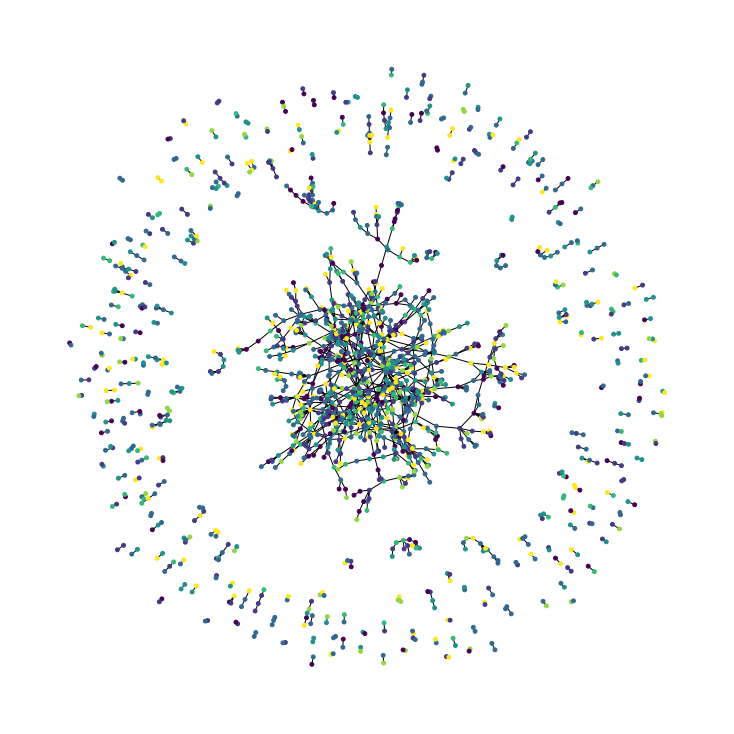

In [ ]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)


[ 462 1911 2002 ... 2372  955  376] aaa


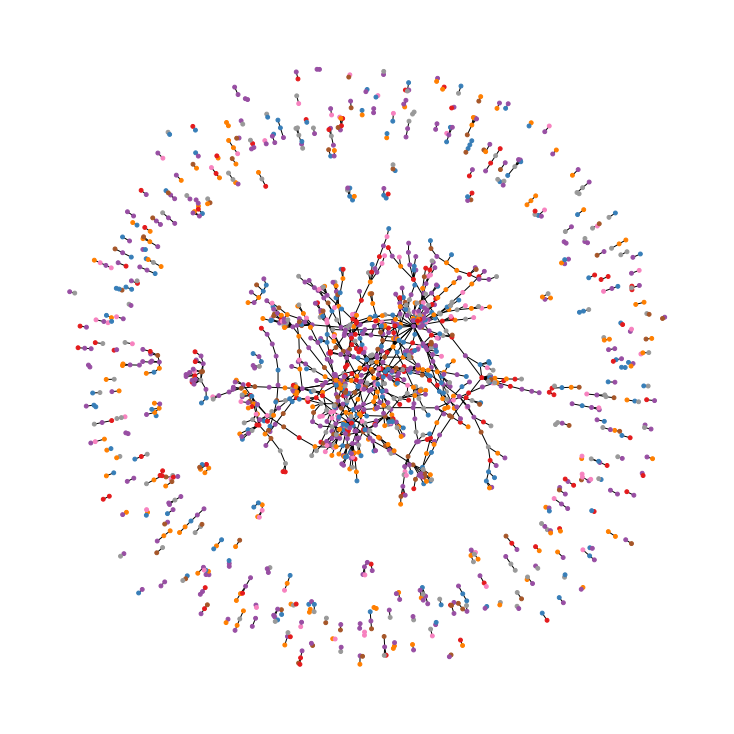

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import count
plt.figure(figsize = (10,10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n = 1500))
colors = [i/len(cora_graph.nodes) for i in range(len(cora_graph.nodes))]
print(papers["paper_id"].unique(),"aaa")
subject = list(papers[papers.index.isin(list(cora_graph.nodes))]["paper_id"])
carac= papers.set_index('subject')
carac= papers.reindex(cora_graph.nodes())
carac['subject']=pd.Categorical(carac['subject'])
carac['subject'].cat.codes
nodes = cora_graph.nodes()
nx.draw_spring(cora_graph,node_size = 15,node_color=carac['subject'].cat.codes, cmap=plt.cm.Set1)

In [ ]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.7
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])
    

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1920, 1435)
Test data shape: (788, 1435)


In [ ]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [ ]:

def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


In [ ]:

def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


In [ ]:

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


In [ ]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]
# print(y_train)

1497    0
657     4
161     3
2306    2
210     4
       ..
1939    2
2376    2
215     0
101     2
827     3
Name: subject, Length: 1920, dtype: int64


In [ ]:
# baseline , todo: ab test type 
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [ ]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
7/7 [==============================] - 5s 119ms/step - loss: 3.6334 - acc: 0.1816 - val_loss: 1.9201 - val_acc: 0.1779
Epoch 2/300
7/7 [==============================] - 0s 24ms/step - loss: 2.7555 - acc: 0.2294 - val_loss: 1.9121 - val_acc: 0.1744
Epoch 3/300
7/7 [==============================] - 0s 24ms/step - loss: 2.2478 - acc: 0.2470 - val_loss: 1.8770 - val_acc: 0.2740
Epoch 4/300
7/7 [==============================] - 0s 27ms/step - loss: 1.9851 - acc: 0.2954 - val_loss: 1.8884 - val_acc: 0.2206
Epoch 5/300
7/7 [==============================] - 0s 28ms/step - loss: 1.9371 - acc: 0.2778 - val_loss: 1.8747 - val_acc: 0.3594
Epoch 6/300
7/7 [==============================] - 0s 27ms/step - loss: 1.8036 - acc: 0.3300 - val_loss: 1.8520 - val_acc: 0.3488
Epoch 7/300
7/7 [==============================] - 0s 27ms/step - loss: 1.7369 - acc: 0.3620 - val_loss: 1.8441 - val_acc: 0.3559
Epoch 8/300
7/7 [==============================] - 0s 28ms/step - loss: 1.6457 - acc: 0.3

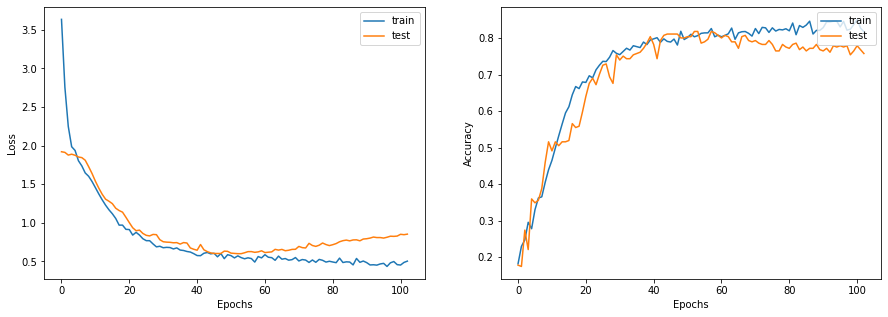

In [ ]:
display_learning_curves(history)

In [ ]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 75.6%


In [ ]:

def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")


In [ ]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Instance 1:
- Case_Based: 0.68%
- Genetic_Algorithms: 1.22%
- Neural_Networks: 20.5%
- Probabilistic_Methods: 21.44%
- Reinforcement_Learning: 0.09%
- Rule_Learning: 0.72%
- Theory: 55.35%
Instance 2:
- Case_Based: 0.66%
- Genetic_Algorithms: 90.8%
- Neural_Networks: 2.07%
- Probabilistic_Methods: 1.42%
- Reinforcement_Learning: 3.72%
- Rule_Learning: 0.19%
- Theory: 1.14%
Instance 3:
- Case_Based: 12.34%
- Genetic_Algorithms: 1.35%
- Neural_Networks: 10.89%
- Probabilistic_Methods: 47.17%
- Reinforcement_Learning: 0.23%
- Rule_Learning: 0.76%
- Theory: 27.26%
Instance 4:
- Case_Based: 2.02%
- Genetic_Algorithms: 1.12%
- Neural_Networks: 56.0%
- Probabilistic_Methods: 38.24%
- Reinforcement_Learning: 0.18%
- Rule_Learning: 0.31%
- Theory: 2.12%
Instance 5:
- Case_Based: 5.7%
- Genetic_Algorithms: 4.06%
- Neural_Networks: 28.82%
- Probabilistic_Methods: 45.88%
- Reinforcement_Learning: 3.25%
- Rule_Learning: 1.35%
- Theory: 10.94%
Instance 6:
- Case_Based: 7.75%
- Genetic_Algorithms: 18

In [ ]:
edges = citations[["source", "target"]].to_numpy().T

# print(edges)
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)

# print(papers.sort_values("paper_id")[feature_names])
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

      term_119  term_189  term_911  term_535  term_153  term_179  term_852  \
163          0         0         0         0         0         0         0   
168          0         0         0         0         0         0         0   
552          0         0         0         0         0         0         0   
1459         0         0         0         0         0         0         0   
554          0         0         0         0         0         0         0   
...        ...       ...       ...       ...       ...       ...       ...   
147          0         0         0         0         0         0         0   
1953         0         0         0         0         0         0         0   
1955         0         0         0         0         0         0         0   
1956         0         0         0         0         0         0         0   
1686         0         0         0         0         0         0         0   

      term_251  term_1145  term_971  ...  term_720  term_1051  

In [ ]:

class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [ ]:

class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


In [ ]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.12052411  0.09073371  0.0378093   0.01376279  0.0965281   0.0550982
  -0.00067211]
 [-0.07085145  0.00261694 -0.04273215  0.01936181 -0.14875937 -0.10452185
   0.05871303]
 [-0.12138802 -0.06018985  0.01548076  0.05411484 -0.10344703 -0.04102816
   0.06390752]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                             

In [ ]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
7/7 [==============================] - 10s 287ms/step - loss: 2.1407 - acc: 0.1948 - val_loss: 1.9091 - val_acc: 0.2847
Epoch 2/300
7/7 [==============================] - 1s 183ms/step - loss: 1.9337 - acc: 0.2866 - val_loss: 1.8819 - val_acc: 0.2847
Epoch 3/300
7/7 [==============================] - 1s 185ms/step - loss: 1.8770 - acc: 0.2766 - val_loss: 1.8775 - val_acc: 0.2883
Epoch 4/300
7/7 [==============================] - 1s 188ms/step - loss: 1.8666 - acc: 0.2847 - val_loss: 1.8714 - val_acc: 0.3167
Epoch 5/300
7/7 [==============================] - 1s 192ms/step - loss: 1.8353 - acc: 0.2960 - val_loss: 1.8634 - val_acc: 0.3310
Epoch 6/300
7/7 [==============================] - 1s 186ms/step - loss: 1.8108 - acc: 0.3080 - val_loss: 1.8585 - val_acc: 0.3025
Epoch 7/300
7/7 [==============================] - 1s 190ms/step - loss: 1.8075 - acc: 0.3130 - val_loss: 1.8381 - val_acc: 0.3416
Epoch 8/300
7/7 [==============================] - 1s 192ms/step - loss: 1.7841 - 

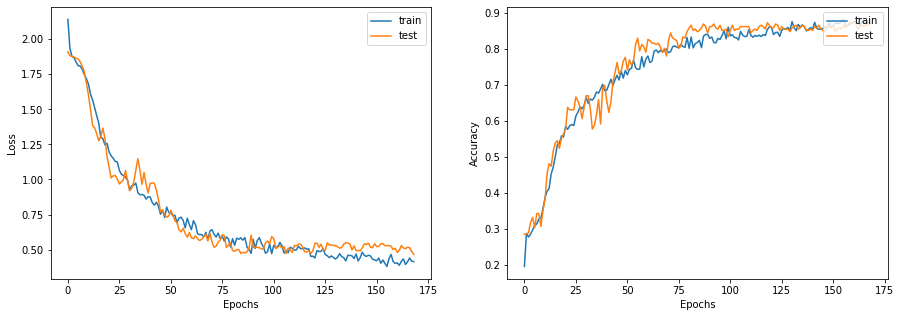

In [ ]:
display_learning_curves(history)

In [ ]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 81.94%


In [ ]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [ ]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
Instance 1:
- Case_Based: 31.32%
- Genetic_Algorithms: 0.47%
- Neural_Networks: 2.56%
- Probabilistic_Methods: 6.55%
- Reinforcement_Learning: 0.97%
- Rule_Learning: 11.98%
- Theory: 46.15%
Instance 2:
- Case_Based: 0.03%
- Genetic_Algorithms: 98.76%
- Neural_Networks: 0.25%
- Probabilistic_Methods: 0.03%
- Reinforcement_Learning: 0.82%
- Rule_Learning: 0.0%
- Theory: 0.1%
Instance 3:
- Case_Based: 0.76%
- Genetic_Algorithms: 0.49%
- Neural_Networks: 29.65%
- Probabilistic_Methods: 46.61%
- Reinforcement_Learning: 0.12%
- Rule_Learning: 0.42%
- Theory: 21.94%
Instance 4:
- Case_Based: 0.06%
- Genetic_Algorithms: 0.01%
- Neural_Networks: 2.44%
- Probabilistic_Methods: 97.39%
- Reinforcement_Learning: 0.0%
- Rule_Learning: 0.0%
- Theory: 0.1%
Instance 5:
- Case_Based: 11.97%
- Genetic_Algorithms: 20.98%
- Neural_Networks: 3.25%
- Probabilistic_Method